Processing PEER-AT2 format files as input time histories for dynamic analyses in FLACv8.1  
Author: William Z. Zakka, UC Berkeley

*Ground Motions for shallows crustal earthquakes in active tectonic regimes can be obtained from the PEER NGA-West2 ground motions database: https://ngawest2.berkeley.edu/*

In [ ]:
#import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os 
import re
import pyrotd
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import detrend

plt.rcParams["font.family"] = "Arial"

In [ ]:
def read_peer_nga_time_history(file_path):
    with open(file_path, 'r') as f:
        # Skip first two lines (title and description)
        next(f)
        next(f)
        next(f)
        # Third line contains 'NPTS= xxx, DT= xxx SEC'
        line = next(f).strip()

        # Extract NPTS and DT using regex
        match = re.search(r'NPTS=\s*(\d+),\s*DT=\s*([\d\.Ee+-]+)', line)
        if not match:
            raise ValueError("Could not parse NPTS and DT from line: " + line)

        npts = int(match.group(1))
        dt = float(match.group(2))

        # Read the acceleration values
        data = []
        for line in f:
            values = [float(val) for val in line.strip().split()]
            data.extend(values)

    if len(data) != npts:
        raise ValueError(f"Expected {npts} data points, but found {len(data)}")

    # Create time vector and DataFrame
    time = [i * dt for i in range(npts)]
    df = pd.DataFrame({'Time (s)': time, 'Acceleration (g)': data})
    return df

In [ ]:
# specify directory
directory = 'time_histories/PEER_format'


## Plot acceleration in all directions

Text(0.5, 1.0, 'VUWS - Kaikoura 2016 - Deconvolved')

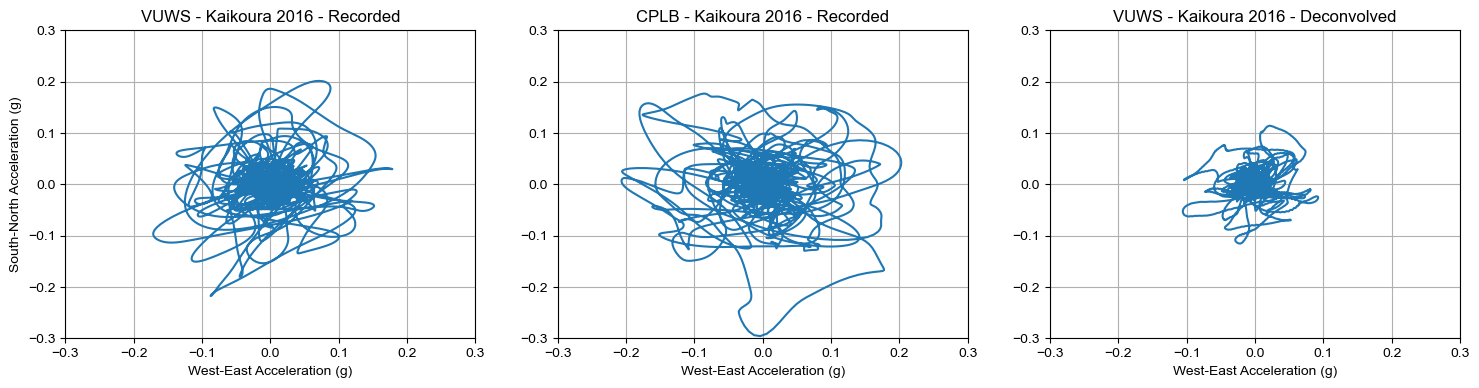

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

axs[0].plot(Kaikoura_VUWS_rec_90['Acceleration (g)'],Kaikoura_VUWS_rec_00['Acceleration (g)'])
axs[0].grid()
axs[0].set_xlim(-0.3,0.3)
axs[0].set_ylim(-0.3,0.3)
axs[0].set_xlabel('West-East Acceleration (g)')
axs[0].set_ylabel('South-North Acceleration (g)')
axs[0].set_title('VUWS - Kaikoura 2016 - Recorded')

axs[1].plot(Kaikoura_CPLB_rec_90['Acceleration (g)'],Kaikoura_CPLB_rec_00['Acceleration (g)'])
axs[1].grid()
axs[1].set_xlim(-0.3,0.3)
axs[1].set_ylim(-0.3,0.3)
axs[1].set_xlabel('West-East Acceleration (g)')
axs[1].set_title('CPLB - Kaikoura 2016 - Recorded')

axs[2].plot(Kaikoura_VUWS_dec_90['Acceleration (g)'],Kaikoura_VUWS_dec_00['Acceleration (g)'])
axs[2].grid()
axs[2].set_xlim(-0.3,0.3)
axs[2].set_ylim(-0.3,0.3)
axs[2].set_xlabel('West-East Acceleration (g)')
axs[2].set_title('VUWS - Kaikoura 2016 - Deconvolved')

## Compute Spectral Acceleration for both components ##

In [4]:
time_step = 0.005 
time_series = [Kaikoura_CPLB_rec_00,Kaikoura_CPLB_rec_90]
osc_damping = 0.05
osc_freqs = np.logspace(-1, 2, 91)
accel = []

for ts in time_series:
    accel.append(pyrotd.calc_spec_accels(
        time_step, ts['Acceleration (g)'], osc_freqs, osc_damping
    ).spec_accel)

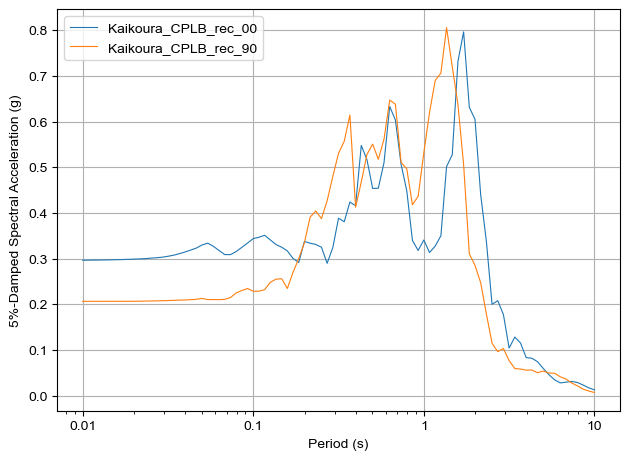

In [5]:
fig, ax = plt.subplots()

for i in range(2):
    ax.plot(1/osc_freqs, accel[i], linewidth=0.8, label=time_series[i].name)
    
ax.set(
    xlabel='Period (s)', xscale='log', alpha=0.8,
    ylabel='5%-Damped Spectral Acceleration (g)'
)
ax.legend()
ax.grid()
fig.tight_layout()
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))

## Compute Rotd50 and Rotd100 spectrums ##

In [7]:
rotated_resp = pyrotd.calc_rotated_spec_accels(time_step, 
    time_series[0]['Acceleration (g)'], time_series[1]['Acceleration (g)'],
    osc_freqs, osc_damping, percentiles=[0,50, 100],
)

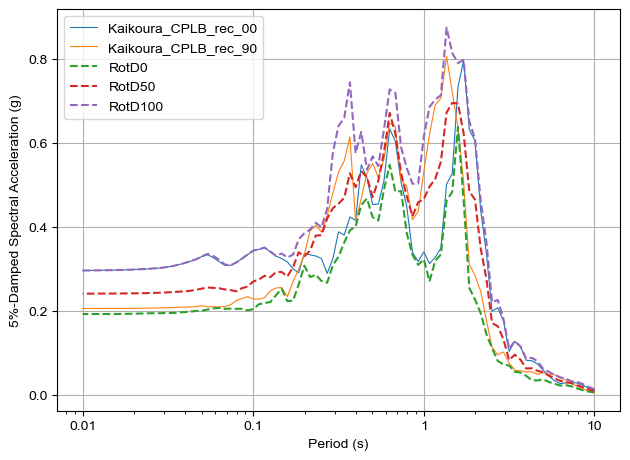

In [8]:
fig, ax = plt.subplots()

for i in range(2):
    ax.plot(1/osc_freqs, accel[i], linewidth=0.8, label=time_series[i].name)

for percentile in np.unique(rotated_resp.percentile):
    selected = rotated_resp[rotated_resp.percentile == percentile]
    ax.plot(1/selected.osc_freq, selected.spec_accel, 
            linestyle='--', label='RotD%d' % percentile)
    
ax.set(
    xlabel='Period (s)', xscale='log', alpha=0.8,
    ylabel='5%-Damped Spectral Acceleration (g)'
)
ax.legend()
ax.grid()
fig.tight_layout()
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))

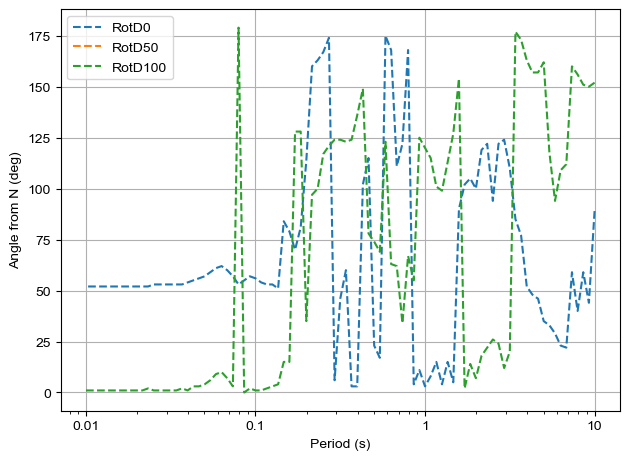

In [9]:
fig, ax = plt.subplots()

for percentile in [0,50, 100]:
    selected = rotated_resp[rotated_resp.percentile == percentile]
    ax.plot(1/selected.osc_freq, selected.angle, 
            linestyle='--', label='RotD%d' % percentile)
    
ax.set(
    xlabel='Period (s)', xscale='log', alpha=0.8,
    ylabel='Angle from N (deg)',
)
ax.legend()
ax.grid()
fig.tight_layout()
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))

## Arias Intensity vs. Time ##

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz

def arias_intensity(time, acceleration):
    """
    Calculate Arias intensity from an acceleration time history and convert it to percentage of the maximum intensity.

    Parameters:
    time (numpy array): Array of time values.
    acceleration (numpy array): Array of acceleration values corresponding to the time array.

    Returns:
    numpy array: Array of Arias intensity values in percentage.
    """
    g = 9.81  # Acceleration due to gravity in m/s^2
    # Calculate squared acceleration
    acceleration_squared = acceleration ** 2
    # Integrate acceleration squared over time to get Arias intensity
    arias_intensity_values = cumtrapz(acceleration_squared, time, initial=0)
    # Apply the constant factor π / 2g
    arias_intensity_values *= np.pi / (2 * g)
    
    # Convert to percentage of the maximum intensity
    max_intensity = np.max(arias_intensity_values)
    if max_intensity == 0:
        return arias_intensity_values  # Avoid division by zero
    arias_intensity_percentage_values = (arias_intensity_values / max_intensity) * 100
    
    return arias_intensity_percentage_values

C:\Users\willi\AppData\Local\Temp\ipykernel_55716\2144988125.py:20: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  arias_intensity_values = cumtrapz(acceleration_squared, time, initial=0)


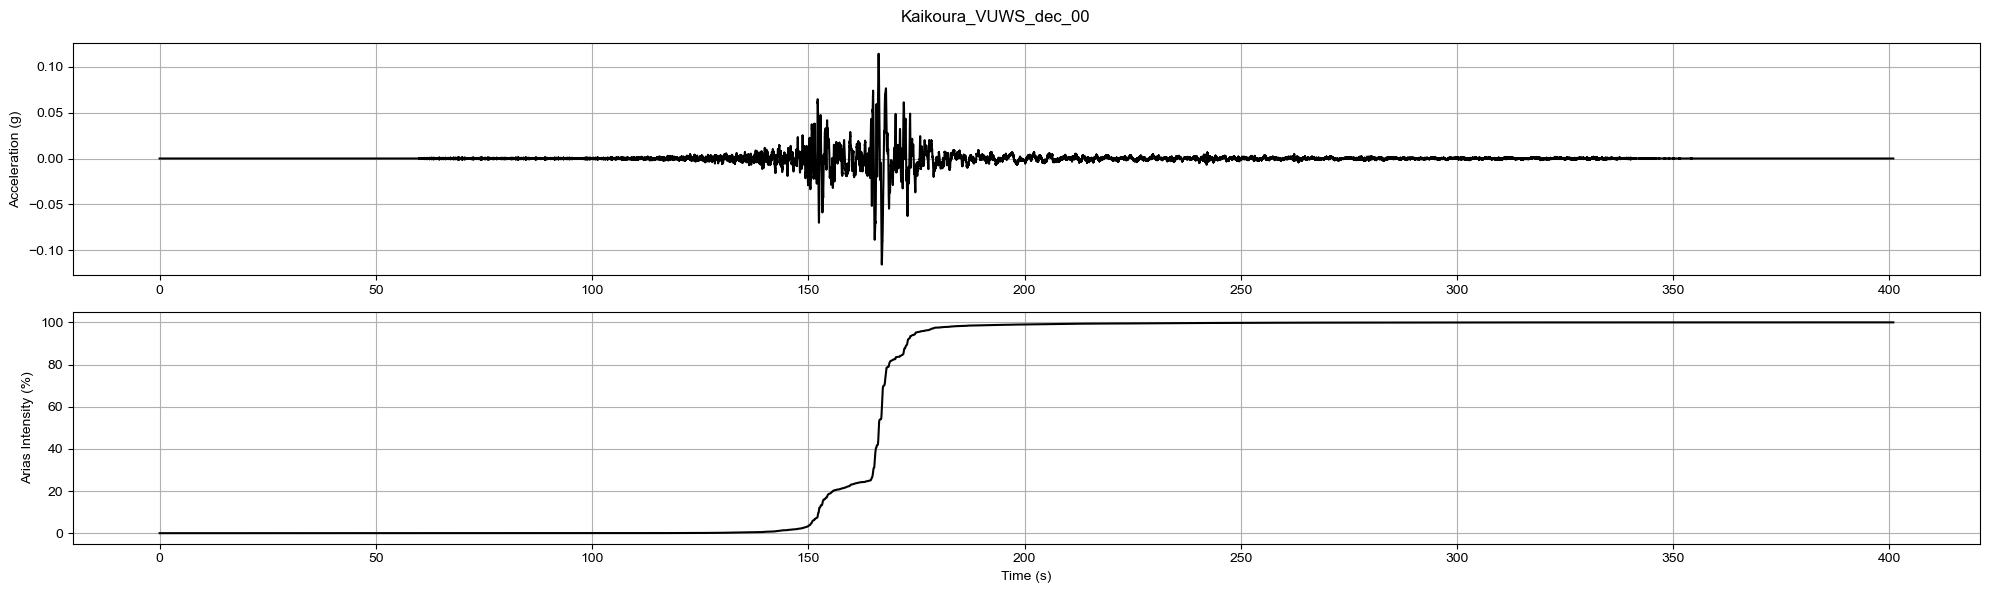

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(20, 6))
arias = arias_intensity(Kaikoura_VUWS_dec_00['time (s)'], Kaikoura_VUWS_dec_00['Acceleration (g)'])
fig.suptitle(Kaikoura_VUWS_dec_00.name)

# Plotting time series
axs[0].plot(Kaikoura_VUWS_dec_00['time (s)'], Kaikoura_VUWS_dec_00['Acceleration (g)'],'k')
axs[0].set(ylabel = 'Acceleration (g)')
axs[0].grid()
#plotting Husid plot
axs[1].plot(Kaikoura_VUWS_dec_00['time (s)'], arias,'k', label='Arias Intensity')
axs[1].set(xlabel = 'Time (s)', ylabel = 'Arias Intensity (%)')
axs[1].grid()

plt.tight_layout()
plt.show()

C:\Users\willi\AppData\Local\Temp\ipykernel_55716\2144988125.py:20: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  arias_intensity_values = cumtrapz(acceleration_squared, time, initial=0)


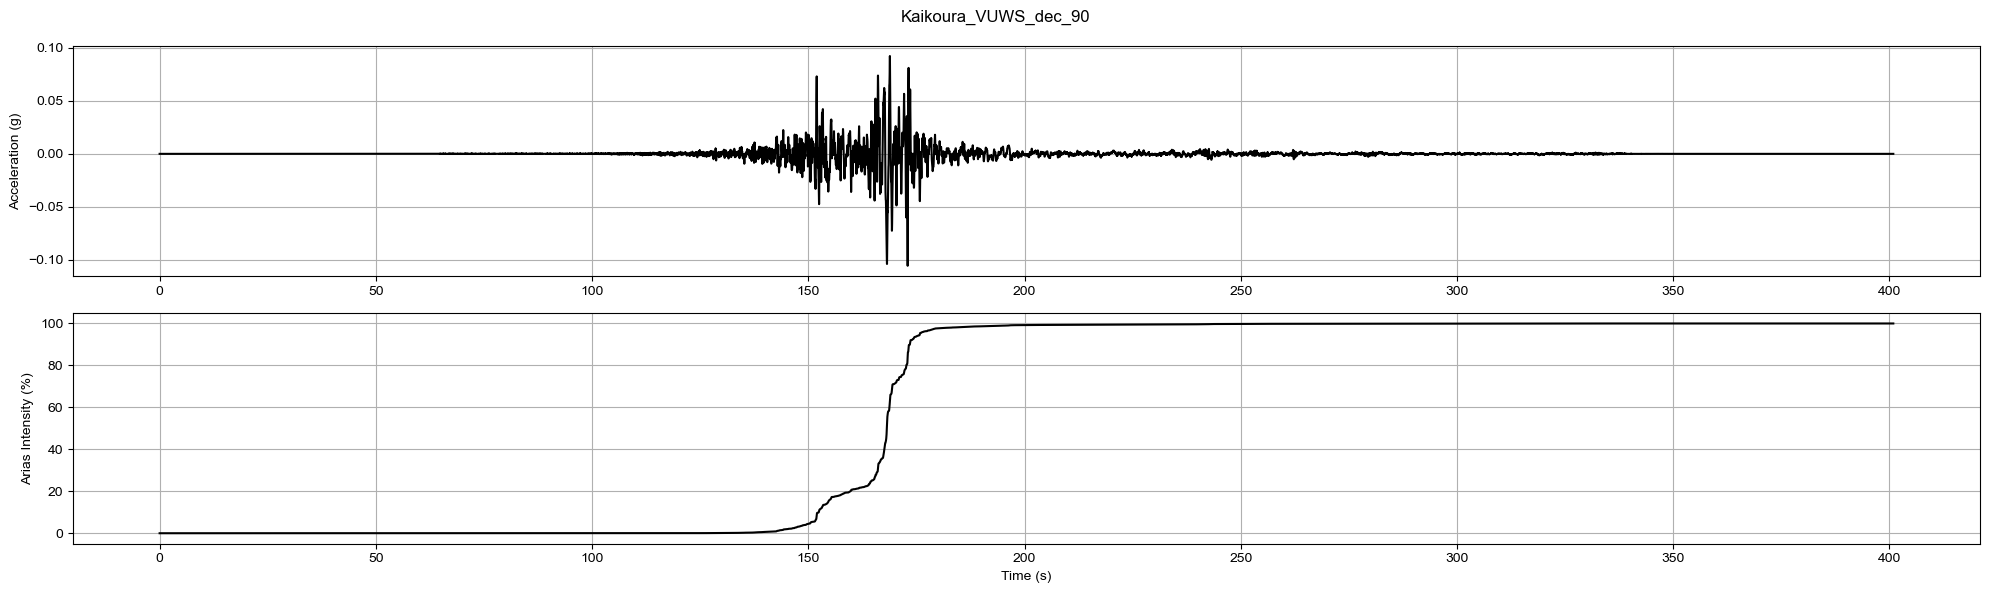

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(20, 6))
arias = arias_intensity(Kaikoura_VUWS_dec_90['time (s)'], Kaikoura_VUWS_dec_90['Acceleration (g)'])
fig.suptitle(Kaikoura_VUWS_dec_90.name)

# Plotting time series
axs[0].plot(Kaikoura_VUWS_dec_90['time (s)'], Kaikoura_VUWS_dec_90['Acceleration (g)'],'k')
axs[0].set(ylabel = 'Acceleration (g)')
axs[0].grid()
#plotting Husid plot
axs[1].plot(Kaikoura_VUWS_dec_90['time (s)'], arias,'k', label='Arias Intensity')
axs[1].set(xlabel = 'Time (s)', ylabel = 'Arias Intensity (%)')
axs[1].grid()

plt.tight_layout()
plt.show()

## Clip time history based on AI ##

C:\Users\willi\AppData\Local\Temp\ipykernel_55716\2144988125.py:20: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  arias_intensity_values = cumtrapz(acceleration_squared, time, initial=0)


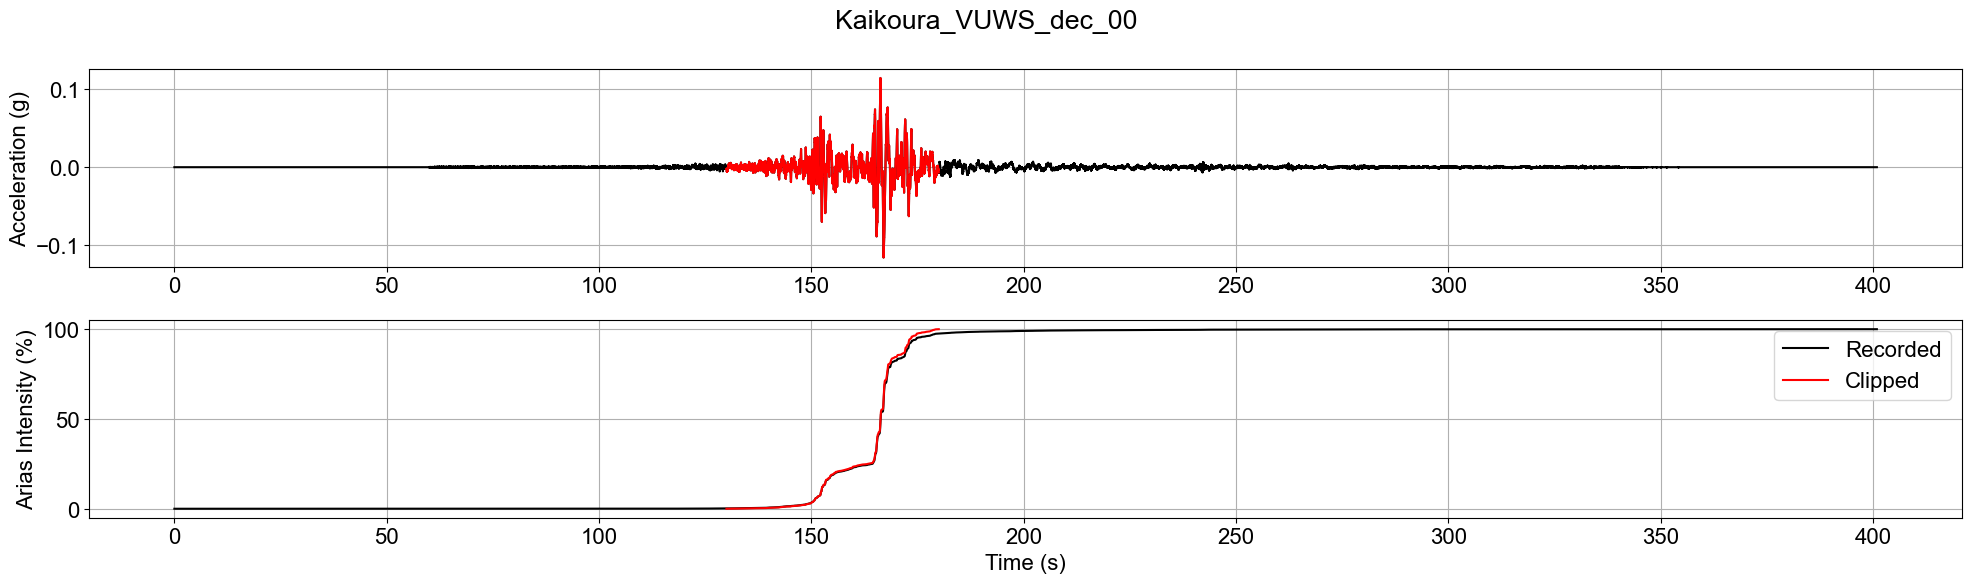

100.0


In [25]:
plt.rcParams.update({'font.size': 16})
# Specify the start and end times for clipping
start_time = 130
end_time = 180

# Calculate the corresponding indices
start_index = int(start_time / dt)
end_index = int(end_time / dt)

# Clip the DataFrame based on the specified start and end times
Kaikoura_VUWS_dec_00_clipped = Kaikoura_VUWS_dec_00.iloc[start_index:end_index+1].copy()

#Overlay clipped time history on complete record and compare AI
fig, axs = plt.subplots(2, 1, figsize=(20, 6))
arias = arias_intensity(Kaikoura_VUWS_dec_00['time (s)'], Kaikoura_VUWS_dec_00['Acceleration (g)'])
arias_clipped = arias_intensity(Kaikoura_VUWS_dec_00_clipped['time (s)'], Kaikoura_VUWS_dec_00_clipped['Acceleration (g)'])
fig.suptitle(Kaikoura_VUWS_dec_00.name)

# Plotting time series
axs[0].plot(Kaikoura_VUWS_dec_00['time (s)'], Kaikoura_VUWS_dec_00['Acceleration (g)'],'k', label='Recorded')
axs[0].plot(Kaikoura_VUWS_dec_00_clipped['time (s)'], Kaikoura_VUWS_dec_00_clipped['Acceleration (g)'],'r', label='Clipped')
axs[0].set(ylabel = 'Acceleration (g)')
axs[0].grid()
#plotting Husid plot
axs[1].plot(Kaikoura_VUWS_dec_00['time (s)'], arias,'k', label='Recorded')
axs[1].plot(Kaikoura_VUWS_dec_00_clipped['time (s)'], arias_clipped,'r', label='Clipped')
axs[1].set(xlabel = 'Time (s)', ylabel = 'Arias Intensity (%)')
axs[1].grid()

plt.legend()
plt.tight_layout()
plt.show()

print(max(arias_clipped))

C:\Users\willi\AppData\Local\Temp\ipykernel_55716\2144988125.py:20: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  arias_intensity_values = cumtrapz(acceleration_squared, time, initial=0)


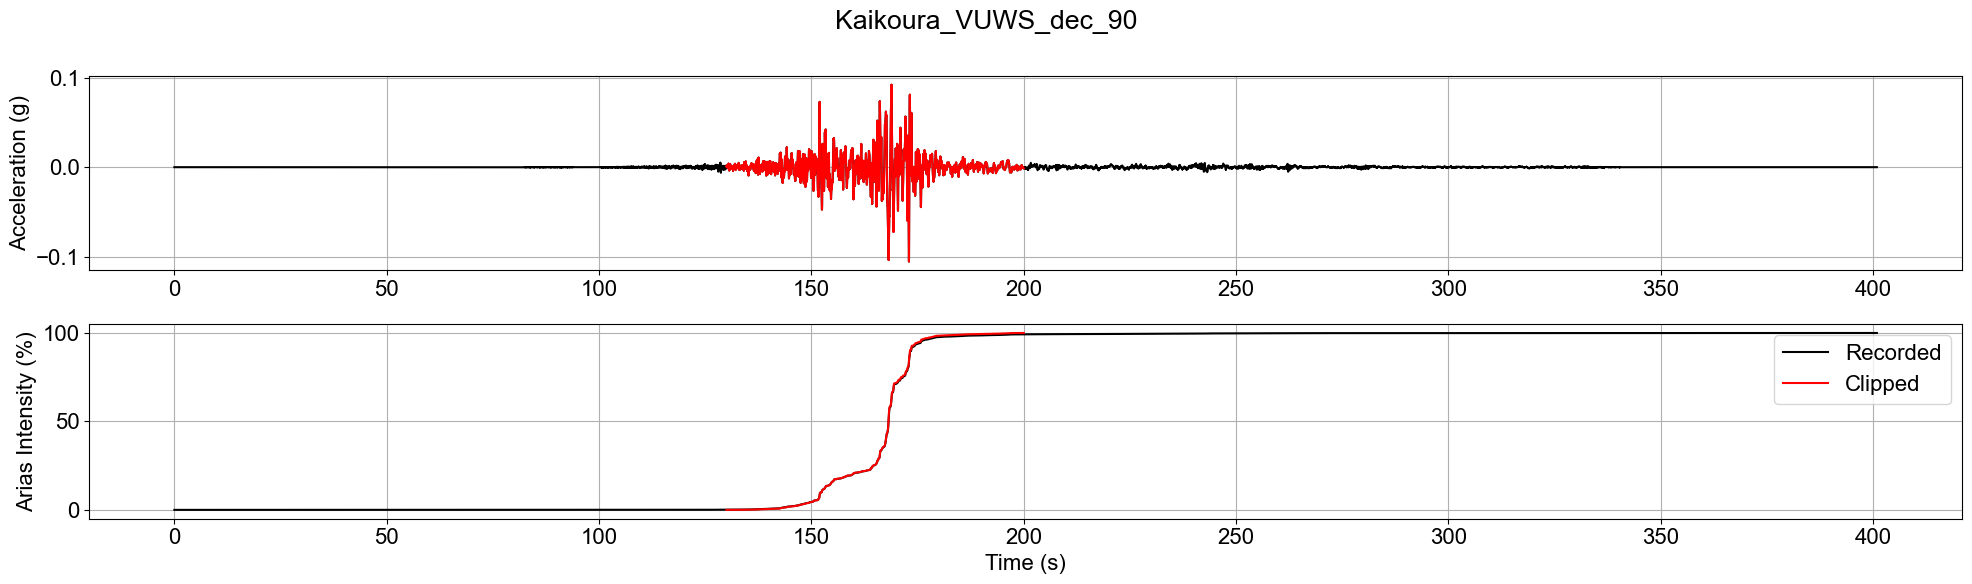

In [16]:
# Specify the start and end times for clipping
start_time = 130
end_time = 200

# Calculate the corresponding indices
start_index = int(start_time / dt)
end_index = int(end_time / dt)

# Clip the DataFrame based on the specified start and end times
Kaikoura_VUWS_dec_90_clipped = Kaikoura_VUWS_dec_90.iloc[start_index:end_index+1].copy()

#Overlay clipped time history on complete record and compare AI
fig, axs = plt.subplots(2, 1, figsize=(20, 6))
arias = arias_intensity(Kaikoura_VUWS_dec_90['time (s)'], Kaikoura_VUWS_dec_90['Acceleration (g)'])
arias_clipped = arias_intensity(Kaikoura_VUWS_dec_90_clipped['time (s)'], Kaikoura_VUWS_dec_90_clipped['Acceleration (g)'])
fig.suptitle(Kaikoura_VUWS_dec_90.name)

# Plotting time series
axs[0].plot(Kaikoura_VUWS_dec_90['time (s)'], Kaikoura_VUWS_dec_90['Acceleration (g)'],'k', label='Recorded')
axs[0].plot(Kaikoura_VUWS_dec_90_clipped['time (s)'], Kaikoura_VUWS_dec_90_clipped['Acceleration (g)'],'r', label='Clipped')
axs[0].set(ylabel = 'Acceleration (g)')
axs[0].grid()
#plotting Husid plot
axs[1].plot(Kaikoura_VUWS_dec_90['time (s)'], arias,'k', label='Recorded')
axs[1].plot(Kaikoura_VUWS_dec_90_clipped['time (s)'], arias_clipped,'r', label='Clipped')
axs[1].set(xlabel = 'Time (s)', ylabel = 'Arias Intensity (%)')
axs[1].grid()

plt.legend()
plt.tight_layout()
plt.show()

## Apply baseline correction and cosine taper ##

C:\Users\willi\AppData\Local\Temp\ipykernel_55716\2984555135.py:20: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity = cumtrapz(acceleration, Kaikoura_VUWS_dec_00_clipped['time (s)'], initial=0)
C:\Users\willi\AppData\Local\Temp\ipykernel_55716\2984555135.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  corrected_velocity = cumtrapz(corrected_acceleration, Kaikoura_VUWS_dec_00_clipped['time (s)'], initial=0)
C:\Users\willi\AppData\Local\Temp\ipykernel_55716\2984555135.py:24: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  displacement = cumtrapz(velocity, Kaikoura_VUWS_dec_00_clipped['time (s)'], initial=0)
C:\Users\willi\AppData\Local\Temp\ipykernel_55716\2984555135.p

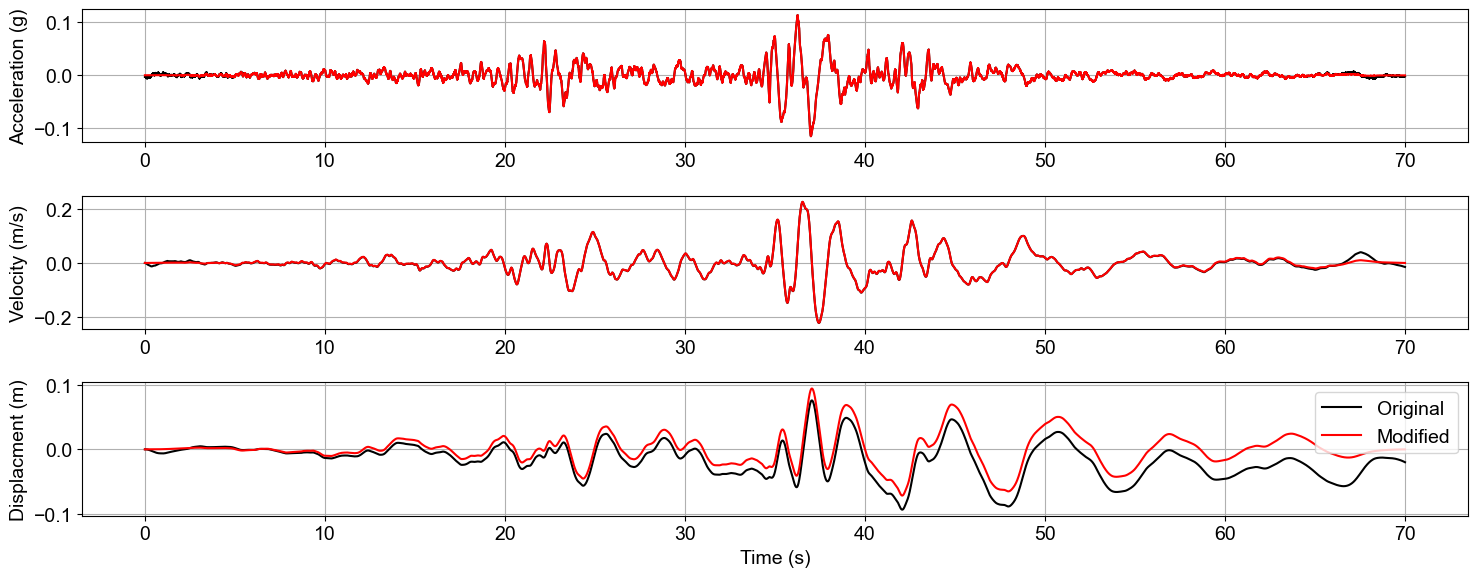

In [22]:
plt.rcParams.update({'font.size': 14})
from obspy.signal.invsim import cosine_taper
from scipy.signal import detrend
import gmspy as gm
from scipy.integrate import cumtrapz

# Reset the time column to start from 0
Kaikoura_VUWS_dec_00_clipped['time (s)'] = np.arange(0, len(Kaikoura_VUWS_dec_00_clipped) * dt, dt)
acceleration = Kaikoura_VUWS_dec_00_clipped['Acceleration (g)'] * 9.81

#apply cosine taper
taper_percentage = 0.2
taper = cosine_taper(len(acceleration), taper_percentage)
taper_acceleration = acceleration * taper

#apply baseline correction
corrected_acceleration = gm.baselinecorr(Kaikoura_VUWS_dec_00_clipped['time (s)'], taper_acceleration, 6)[0]

# Integrate acceleration to get velocity
velocity = cumtrapz(acceleration, Kaikoura_VUWS_dec_00_clipped['time (s)'], initial=0)
corrected_velocity = cumtrapz(corrected_acceleration, Kaikoura_VUWS_dec_00_clipped['time (s)'], initial=0)

# Integrate velocity to get displacement
displacement = cumtrapz(velocity, Kaikoura_VUWS_dec_00_clipped['time (s)'], initial=0)
corrected_displacement = cumtrapz(corrected_velocity, Kaikoura_VUWS_dec_00_clipped['time (s)'], initial=0)

fig, axs = plt.subplots(3, 1, figsize=(15, 6))
#fig.suptitle(Kaikoura_VUWS_dec_00.name)
# Plotting accelerations
axs[0].plot(Kaikoura_VUWS_dec_00_clipped['time (s)'], acceleration/9.81,'k', label = 'Original')
axs[0].plot(Kaikoura_VUWS_dec_00_clipped['time (s)'], corrected_acceleration/9.81,'r' , label = 'Modified')
axs[0].set(ylabel = 'Acceleration (g)')
axs[0].grid()


# Plotting velocities
axs[1].plot(Kaikoura_VUWS_dec_00_clipped['time (s)'], velocity,'k', label = 'Original')
axs[1].plot(Kaikoura_VUWS_dec_00_clipped['time (s)'], corrected_velocity,'r', label = 'Modified')
axs[1].set(ylabel = 'Velocity (m/s)')
axs[1].grid()

# Plotting displacements
axs[2].plot(Kaikoura_VUWS_dec_00_clipped['time (s)'], displacement,'k', label = 'Original')
axs[2].plot(Kaikoura_VUWS_dec_00_clipped['time (s)'], corrected_displacement,'r', label = 'Modified')
axs[2].set(ylabel = 'Displacment (m)', xlabel = 'Time (s)')
axs[2].grid()

plt.tight_layout()
plt.legend()
plt.show()


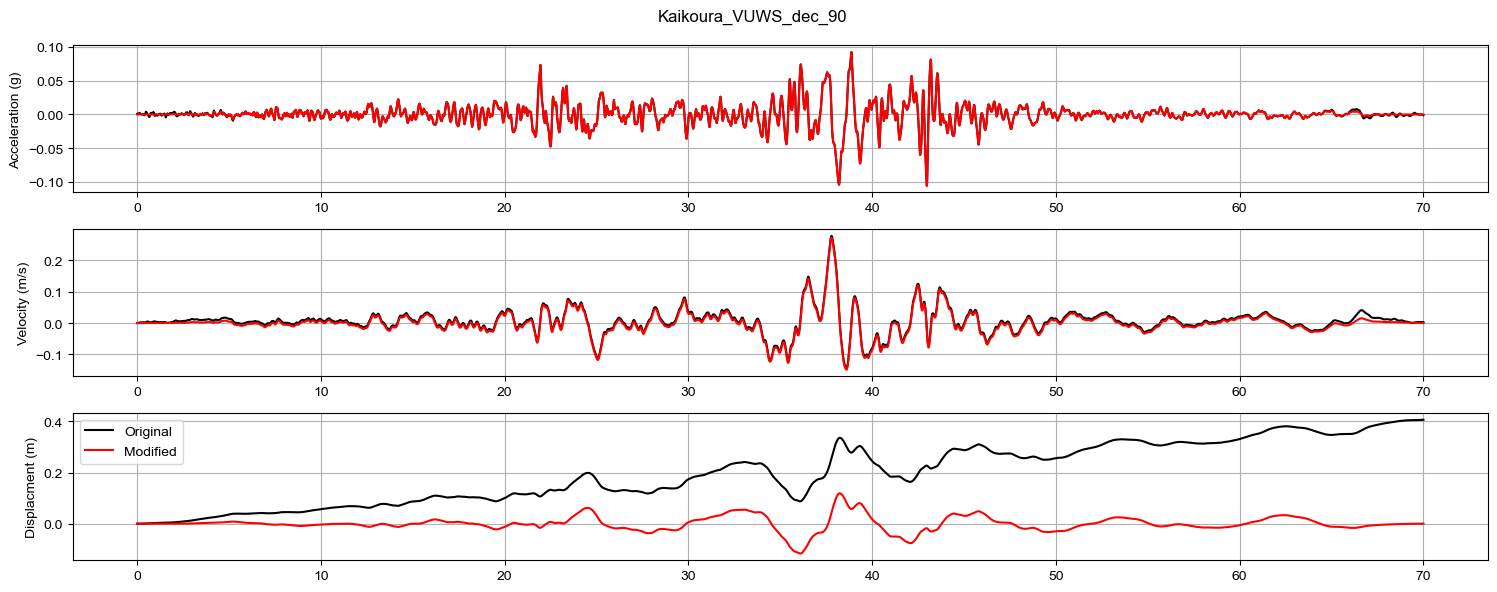

In [17]:
from obspy.signal.invsim import cosine_taper
from scipy.signal import detrend
import gmspy as gm
from scipy.integrate import cumtrapz

# Reset the time column to start from 0
Kaikoura_VUWS_dec_90_clipped['time (s)'] = np.arange(0, len(Kaikoura_VUWS_dec_90_clipped) * dt, dt)
acceleration = Kaikoura_VUWS_dec_90_clipped['Acceleration (g)'] * 9.81

#apply cosine taper
taper_percentage = 0.2
taper = cosine_taper(len(acceleration), taper_percentage)
taper_acceleration = acceleration * taper

#apply baseline correction
corrected_acceleration90 = gm.baselinecorr(Kaikoura_VUWS_dec_90_clipped['time (s)'], taper_acceleration, 6)[0]

# Integrate acceleration to get velocity
velocity90 = cumtrapz(acceleration, Kaikoura_VUWS_dec_90_clipped['time (s)'], initial=0)
corrected_velocity90 = cumtrapz(corrected_acceleration90, Kaikoura_VUWS_dec_00_clipped['time (s)'], initial=0)

# Integrate velocity to get displacement
displacement90 = cumtrapz(velocity, Kaikoura_VUWS_dec_90_clipped['time (s)'], initial=0)
corrected_displacement90 = cumtrapz(corrected_velocity90, Kaikoura_VUWS_dec_90_clipped['time (s)'], initial=0)

fig, axs = plt.subplots(3, 1, figsize=(15, 6))
fig.suptitle(Kaikoura_VUWS_dec_90.name)
# Plotting accelerations
axs[0].plot(Kaikoura_VUWS_dec_90_clipped['time (s)'], acceleration/9.81,'k', label = 'Original')
axs[0].plot(Kaikoura_VUWS_dec_90_clipped['time (s)'], corrected_acceleration90/9.81,'r' , label = 'Modified')
axs[0].set(ylabel = 'Acceleration (g)')
axs[0].grid()

# Plotting velocities
axs[1].plot(Kaikoura_VUWS_dec_90_clipped['time (s)'], velocity,'k', label = 'Original')
axs[1].plot(Kaikoura_VUWS_dec_90_clipped['time (s)'], corrected_velocity90,'r', label = 'Modified')
axs[1].set(ylabel = 'Velocity (m/s)')
axs[1].grid()

# Plotting displacements
axs[2].plot(Kaikoura_VUWS_dec_90_clipped['time (s)'], displacement,'k', label = 'Original')
axs[2].plot(Kaikoura_VUWS_dec_90_clipped['time (s)'], corrected_displacement90,'r', label = 'Modified')
axs[2].set(ylabel = 'Displacment (m)')
axs[2].grid()


plt.tight_layout()
plt.legend()
plt.show()


## Format Velocity Time History for FLAC Analysis and Save

In [70]:
velocity_df = Kaikoura_VUWS_dec_00_clipped.copy()  


velocity_df['velocity (m/s)'] = corrected_velocity

velocity_df = velocity_df['velocity (m/s)']
velocity_df.fillna(0, inplace=True)

# Define a custom format function
def format_scientific_notation(val):
    return f"{val:.2E}"

# Apply the format function to the 'velocity (m/s)' column
velocity_df = velocity_df.apply(format_scientific_notation)

info = "Kaikoura 2016 Deconvolved VUVS Velocity (m/s)"
length = str(len(velocity_df)) + '\t0.005'
#save velocity time history
output_file_path = r'C:\Users\willi\OneDrive\Desktop\Research\Site Response CPLB\ANALYSIS 1 - CPT032\Kaikoura2016_clipped_VUWS00.txt'
with open(output_file_path, 'w') as f:
    f.write(info + '\n')
    f.write(length + '\n')
    #velocity_df.to_csv(f, index = False, header = False)
    values = velocity_df.tolist()
    f.write('\n'.join(values))

In [59]:
velocity_df = Kaikoura_VUWS_dec_00.copy()  

velocity = cumtrapz(Kaikoura_VUWS_dec_00['Acceleration (g)']*9.81, Kaikoura_VUWS_dec_00['time (s)'], initial=0)

velocity_df['velocity (m/s)'] = velocity

velocity_df = velocity_df['velocity (m/s)']
velocity_df.fillna(0, inplace=True)

# Define a custom format function
def format_scientific_notation(val):
    return f"{val:.6E}"

# Apply the format function to the 'velocity (m/s)' column
velocity_df = velocity_df.apply(format_scientific_notation)

info = "Kaikoura 2016 Deconvolved VUVS Velocity (m/s)"
length = str(len(velocity_df)) + '\t0.005'
#save velocity time history
output_file_path = r'C:\Users\willi\OneDrive\Desktop\Research\Site Response CPLB\Input Ground Motions\Kaikoura2016_VUWS_decon_vel.txt'
with open(output_file_path, 'w') as f:
    f.write(info + '\n')
    f.write(length + '\n')
    velocity_df.to_csv(f, index = False, header = False)

In [19]:
velocity_df = Kaikoura_VUWS_dec_90_clipped.copy()  


velocity_df['velocity (m/s)'] = corrected_velocity90

velocity_df = velocity_df['velocity (m/s)']
velocity_df.fillna(0, inplace=True)

# Define a custom format function
def format_scientific_notation(val):
    return f"{val:.2E}"

# Apply the format function to the 'velocity (m/s)' column
velocity_df = velocity_df.apply(format_scientific_notation)

info = "Kaikoura 2016 Deconvolved VUVS Velocity (m/s)"
length = str(len(velocity_df)) + '\t0.005'
#save velocity time history
output_file_path = r'C:\Users\willi\OneDrive\Desktop\Research\Site Response CPLB\Input Ground Motions\Kaikoura2016_clipped_VUWS90.txt'
with open(output_file_path, 'w') as f:
    f.write(info + '\n')
    f.write(length + '\n')
    #velocity_df.to_csv(f, index = False, header = False)
    values = velocity_df.tolist()
    f.write('\n'.join(values))

In [ ]:
plt.figure(figsize=(18,3))
plt.plot(Kaikoura_VUWS_dec_00['time (s)'],velocity_df)

In [ ]:
Kaikoura_VUWS_dec_00

In [ ]:
kaikoura = pd.read_csv(r'C:\Users\willi\OneDrive\Desktop\Research\Site Response CPLB\ANALYSIS 1 - CPT032\Kaikoura2016_VUWS_decon_clipped_vel.txt', skiprows = 2, names = ['Velocity'])
num_rows = len(kaikoura)
dt = 0.005
kaikoura['time (s)'] = np.arange(0, num_rows * dt, dt)
loma_prieta = pd.read_csv(r'C:\Users\willi\OneDrive\Desktop\Research\Site Response CPLB\ANALYSIS 1 - CPT032\Scaled0.08g_YBI_motion.txt', skiprows = 2, names = ['Velocity'])
num_rows = len(loma_prieta)
dt = 0.005
loma_prieta['time (s)'] = np.arange(0, num_rows * dt, dt)

In [ ]:
plt.figure(figsize=(18,3))
plt.plot(kaikoura['time (s)'],kaikoura['Velocity'])

In [ ]:
plt.figure(figsize=(18,3))
plt.plot(loma_prieta['time (s)'],loma_prieta['Velocity'])